# Tema 6 (Apoyo) — Árboles de Decisión (con código y ejemplos reales)

En este notebook trabajaremos **solo con Árboles de Decisión** y un dataset real para aprender:
- cómo entrenar un árbol,
- cómo evaluarlo,
- cómo visualizarlo,
- y cómo evitar el sobreajuste.

---
## 1) Cargar librerías y dataset real (Iris)

Usaremos el dataset **Iris** de `scikit-learn` (real y muy usado en ML) para clasificar especies de flores.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cargar dataset Iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="species")

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 2) Dividir en entrenamiento y test

Usamos 80% para entrenar y 20% para evaluar. Así evitamos engañarnos con el rendimiento.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (120, 4)
Test size: (30, 4)


## 3) Entrenar un Árbol de Decisión simple

Empezamos con un árbol básico. Luego veremos cómo controlar su complejidad.

In [10]:
tree_simple = DecisionTreeClassifier(random_state=42)
tree_simple.fit(X_train, y_train)

y_pred = tree_simple.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, target_names=iris.target_names))

Accuracy: 0.9333333333333333

Reporte de clasificación:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



## 4) Matriz de confusión

Nos permite ver en qué clases se equivoca el modelo.

## 4.1) Criterios de división: Gini, Entropía y Ganancia de Información

Cuando el árbol decide **dónde dividir**, evalúa qué corte **separa mejor las clases**.

### ✅ Gini (por defecto)
- Mide qué tan “mezcladas” están las clases.
- **Gini = 0** significa nodo puro (solo una clase).
- Se calcula como:
  $$Gini = 1 - \sum p_i^2$$

### ✅ Entropía
- Mide la “incertidumbre” del nodo.
- **Entropía = 0** significa nodo puro.
- Se calcula como:
  $$Entropía = -\sum p_i \log_2(p_i)$$

### ✅ Ganancia de Información
- Es la **reducción de impureza** al hacer una división.
- Cuanto mayor la ganancia, **mejor el corte**.

---

### 🤔 ¿Cuál usar?
- **Gini** suele ser más rápido.
- **Entropía** puede dar árboles ligeramente diferentes, pero suele ser parecido.
- En la práctica, **la diferencia es pequeña**: prueba ambos si quieres comparar.

In [11]:
# Comparar Gini vs Entropía con el mismo dataset

tree_gini = DecisionTreeClassifier(criterion="gini", random_state=42)
tree_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42)

tree_gini.fit(X_train, y_train)
tree_entropy.fit(X_train, y_train)

pred_gini = tree_gini.predict(X_test)
pred_entropy = tree_entropy.predict(X_test)

print("Accuracy Gini:", accuracy_score(y_test, pred_gini))
print("Accuracy Entropía:", accuracy_score(y_test, pred_entropy))

Accuracy Gini: 0.9333333333333333
Accuracy Entropía: 0.9333333333333333


## 4.2) Elección del árbol óptimo (profundidad)

El objetivo es **encontrar un balance** entre:
- un árbol muy profundo (overfitting),
- y un árbol muy simple (underfitting).

### ✅ Estrategia práctica

1. Probar varias profundidades (`max_depth`).
2. Medir rendimiento en test o con validación cruzada.
3. Elegir la profundidad con mejor rendimiento general.

---

Mejor profundidad: 3
Accuracy asociado: 0.9666666666666667


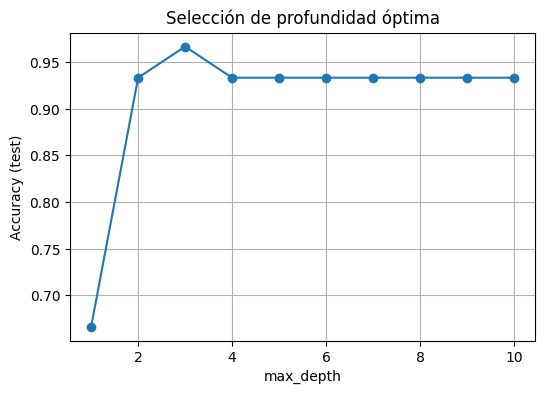

In [12]:
# Buscar la mejor profundidad usando validación simple
profundidades = range(1, 11)
accuracies = []

for d in profundidades:
    tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    accuracies.append(accuracy_score(y_test, pred))

best_depth = profundidades[int(np.argmax(accuracies))]
print("Mejor profundidad:", best_depth)
print("Accuracy asociado:", max(accuracies))

plt.figure(figsize=(6,4))
plt.plot(profundidades, accuracies, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Accuracy (test)")
plt.title("Selección de profundidad óptima")
plt.grid(True)
plt.show()

In [13]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=iris.target_names, columns=iris.target_names)
cm_df

,setosa,versicolor,virginica
setosa,10,0,0
versicolor,0,9,1
virginica,0,1,9


## 5) Visualizar el árbol

Esto ayuda a entender cómo toma decisiones el modelo.

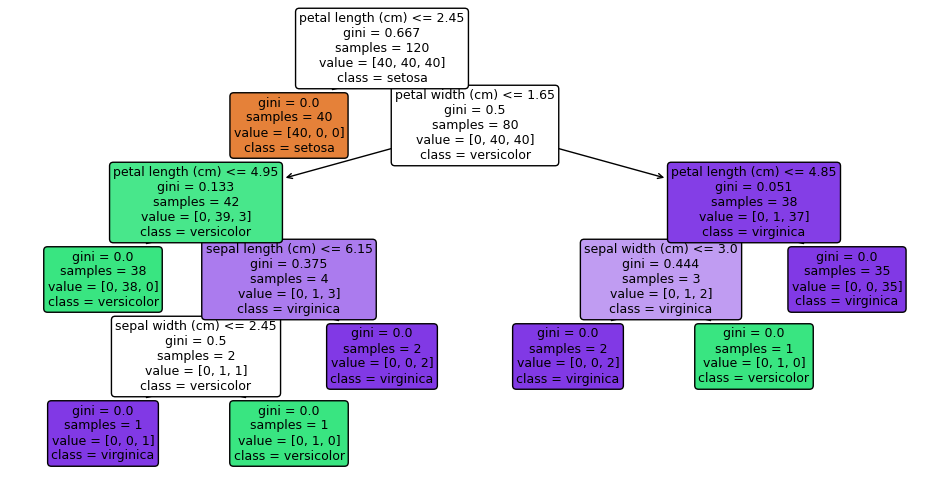

In [14]:
plt.figure(figsize=(12, 6))
plot_tree(
    tree_simple,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.show()

## 6) Controlar overfitting (árbol podado)

Limitar la profundidad ayuda a reducir la varianza.

In [15]:
tree_pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_pruned.fit(X_train, y_train)

pred_pruned = tree_pruned.predict(X_test)

print("Accuracy (árbol podado):", accuracy_score(y_test, pred_pruned))
print("\nReporte:\n", classification_report(y_test, pred_pruned, target_names=iris.target_names))

Accuracy (árbol podado): 0.9666666666666667

Reporte:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## 7) Importancia de variables

Nos dice qué características pesan más en la decisión del modelo.

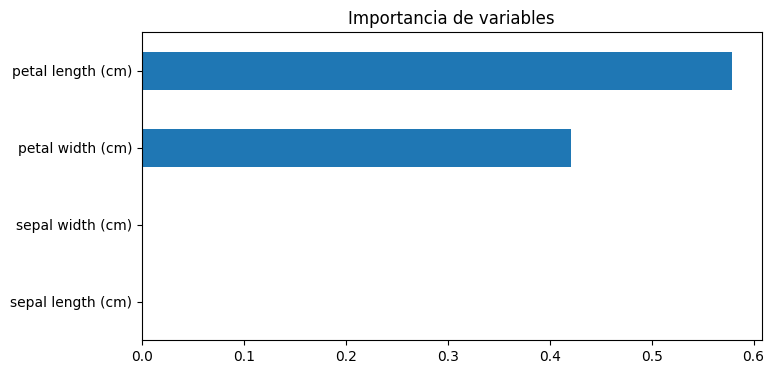

In [16]:
importancias = pd.Series(tree_pruned.feature_importances_, index=iris.feature_names)
importancias.sort_values().plot(kind='barh', figsize=(8, 4), title='Importancia de variables')
plt.show()

## 8) Conclusiones rápidas

- Árboles simples son fáciles de entender pero pueden sobreajustar.
- Limitar `max_depth` ayuda a controlar la varianza.
- Mirar `train vs test` es clave para detectar overfitting.
- Con datasets reales, Random Forest suele mejorar al árbol simple (veremos luego).